<a href="https://colab.research.google.com/github/imnadiarasheed/DIP/blob/main/Assign_2(Tech_7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...


<ipython-input-1-eab949423d12>:170: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  hes_img = hessian(eq_img)


Using bilateral filter...
Removing noise...
Removing retina's circle...
Image processing done.




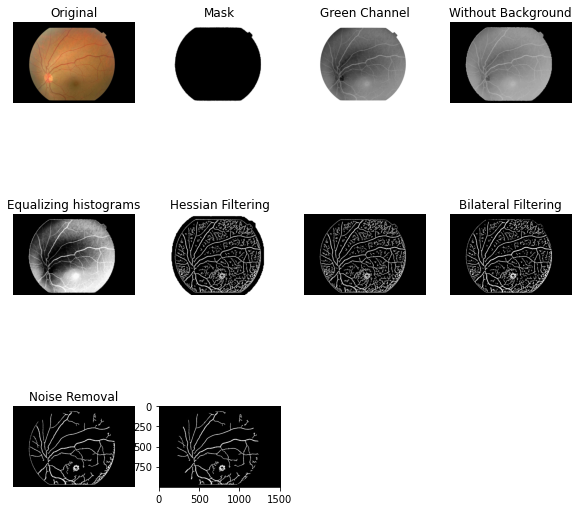

In [1]:
## Image manipulation and morphology

import matplotlib.pyplot as plt
import cv2
import numpy as np
from os import listdir
from skimage.filters import frangi, hessian
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

''' Input image directory
IMG_DIR = 'drive/MyDrive/images'
# List of files in the folder above
image_names = [f"{IMG_DIR}/imgg/{img}" for img in listdir(f"{IMG_DIR}/imgg")]
mask_names = [f"{IMG_DIR}/ground_truth/{img}" for img in listdir(f"{IMG_DIR}/ground_truth")]'''

def invert_colors(img):
    '''
    Invert colors in the image.
    :param img: - input image
    :return new_image: - image with inverted colors
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image


def remove_background(img, mask):
    '''
    Remove background using mask, in other words set pixels to black if the pixel of the
    same coordinates in mask is not black.
    :param img: - input image
    :param mask: - mask image used to remove background
    :return new_image: - image without the background
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = img[x][y] if mask[x][y] == 0 else 0
    return new_image


# 1. Read image
def read_image(filepath):
    '''
    Standard function to read image
    :param filepath: - image filepath
    :return img: - image as numpy array
    '''
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    # OpenCV 2 reads images in BGR, so we convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# 2. Extract background mask from image
def get_mask(img, threshold = 5):
    '''
    Extract background mask from image by removing pixels above threshold and converting those
    below it to white.
    :param img: - input image
    :param threshold: - the threshold
    :return img_mask: - result mask
    '''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img_mask):
        for y, _ in enumerate(row):
            # Thresholding
            img_mask[x][y] = 255 if img[x][y] < threshold else 0
    return img_mask


# 3. Extract green channel from the image
def get_green_channel(img):
    '''
    Extract green channel from image.
    :param img: - input image
    :return green_img: - result image with only green channel
    '''
    _, green_img, _ = cv2.split(img)
    green_img = invert_colors(green_img)
    return green_img


# 4. Small noise removal
def remove_noise(img, min_size = 600):
    '''
    Remove small dots from image.
    :param img: - input image
    :param min_size: - minimum size of objects to not be removed
    :return clear_img: - image without noise
    '''
    # Detect connected objects in image
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    # Extract sizes
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        # If the object is bigger than min_size, redraw it on output image
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img


# 5. Remove big circle around retina
def remove_retina_circle(img, base_offset=2000):
    '''
    Remove big circle around retina using Hough circles.
    Algorithm will search until it finds one circle of specific size in the image.
    If that is not possible, no changes are made.
    :param img: - input image
    :param base_offset: - start searching from this size (speeds up computation)
    :return no_retina_img: - image without the circle
    '''
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        # Detect Hough circles from base_offset + offset size
        detections = cv2.HoughCircles(no_retina_img, cv2.HOUGH_GRADIENT, 1.5, base_offset + offset)
        # Stop if no circles can be detected
        if detections is None:
            return no_retina_img
        # If only one circle is detected, finish the search
        if len(detections[0]) == 1:
            break
        # IOtherwise increase size
        offset += 100
    for (x, y, r) in detections[0]:
        # Draw a circle to be removed
        cv2.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    # Circle removal
    no_retina_img = no_retina_img - circle
    return no_retina_img
    

def detect_veins(filepath):
    '''
    Function that merges the functionality above.
    :param filepath: - input image path
    '''
    # create figure
    fig = plt.figure(figsize=(10, 10))
      
    # setting values to rows and column variables
    rows = 3
    columns = 4

    print("Reading image...")
    img = read_image(filepath)
    print("Extracting mask...")
    img_mask = get_mask(img)

    fig.add_subplot(rows, columns, 1)
    plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title("Original")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img_mask, cmap='gray'), plt.axis('off'), plt.title("Mask")

    print("Extracting green channel...")
    img = get_green_channel(img)
    print("Removing background...")
    bck_img = remove_background(img, img_mask)
    print("Equalizing histograms...")
    eq_img = cv2.equalizeHist(bck_img)
    print("Extracting veins using hessian...")
    hes_img = hessian(eq_img)
    veins = remove_background(hes_img, img_mask)
    print("Using bilateral filter...")
    filtered_img = cv2.bilateralFilter(veins,7,75,75)
    print("Removing noise...")
    clear_img = remove_noise(filtered_img)
    print("Removing retina's circle...")
    result = remove_retina_circle(clear_img)
    print("Image processing done.")
    print("\n")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title("Green Channel")
    fig.add_subplot(rows, columns, 4)
    plt.imshow(bck_img, cmap='gray'), plt.axis('off'), plt.title("Without Background")
    fig.add_subplot(rows, columns, 5)
    plt.imshow(eq_img, cmap='gray'), plt.axis('off'), plt.title("Equalizing histograms")
    fig.add_subplot(rows, columns, 6)
    plt.imshow(hes_img, cmap='gray'), plt.axis('off'), plt.title("Hessian Filtering")
    fig.add_subplot(rows, columns, 7)
    plt.imshow(veins, cmap='gray'), plt.axis('off')
    fig.add_subplot(rows, columns, 8)
    plt.imshow(filtered_img, cmap='gray'), plt.axis('off'), plt.title("Bilateral Filtering")
    fig.add_subplot(rows, columns, 9)
    plt.imshow(clear_img, cmap='gray'), plt.axis('off'), plt.title("Noise Removal")
    fig.add_subplot(rows, columns, 10)

    return result


if __name__ == '__main__':
    # replace input_file with your file path
    veins = detect_veins('drive/MyDrive/images/assign-2/IM000001.JPG')
    plt.imshow(veins, cmap='gray')
    plt.show()

In [2]:
number_list = np.array(veins)
(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts))
print(frequencies), print(veins.shape)

[[      0       1     255]
 [1327754   99100   77146]]
(1000, 1504)


(None, None)

[[      0       1]
 [1426854   77146]]


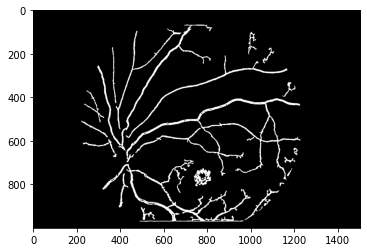

In [3]:
predicted = cv2.threshold(veins, 1, 1, cv2.THRESH_BINARY)[1]
number_list = np.array(predicted)
(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts))
print(frequencies)
plt.imshow(predicted, cmap='gray')
plt.show()

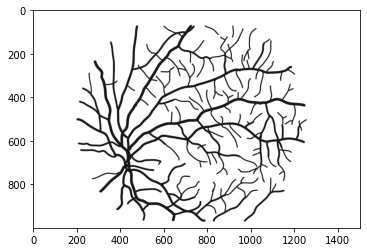

In [4]:
mask = cv2.imread('drive/MyDrive/images/assign-2/IM000001--vessels.jpg', 0)
plt.imshow(mask, cmap='gray')
plt.show()

[[      0       1]
 [1359232  144768]]


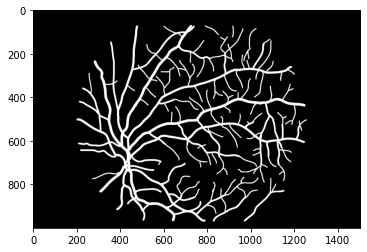

In [5]:
actual = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY_INV)[1]
number_list = np.array(actual)
(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts))
print(frequencies)
plt.imshow(actual, cmap='gray')
plt.show()

In [6]:
output = (((predicted * 2) + actual))
unique_elements, counts = np.unique(output, return_counts=True)
print(unique_elements, counts)
TN, FN, FP, TP = counts
ACC = (TP + TN)/ (TP + TN + FP + FN)
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
diceCoff = 2*TP / (FN + (2*TP) + FP)
print([ACC, TPR, FPR, diceCoff])

[0 1 2 3] [1342779   84075   16453   60693]
[0.9331595744680851, 0.4192432029177719, 0.012104629673227235, 0.5469956830123381]


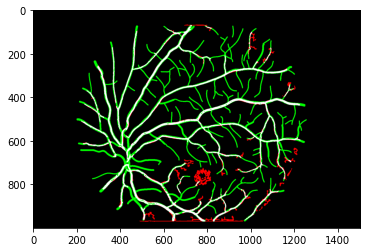

In [7]:
labelled_image = np.zeros((output.shape[0], output.shape[1],3), dtype=int)
for x in range(0, output.shape[0]):
  for y in range(0, output.shape[1]):
    if (output[x,y] == unique_elements[0]):
      labelled_image[x,y] = (0,0,0)
    elif (output[x,y] == unique_elements[1]):
      labelled_image[x,y] = (0,255,0)
    elif (output[x,y] == unique_elements[2]):
      labelled_image[x,y] = (255,0,0)
    elif (output[x,y] == unique_elements[3]):
      labelled_image[x,y] = (255,255,255)
plt.imshow(labelled_image)
plt.show()

Using Confusion Matrix

In [8]:
from sklearn import metrics

actual1=actual.reshape(-1)
predicted1=predicted.reshape(-1)
#print(actual1), print(predicted1)

confusion_matrix = metrics.confusion_matrix(actual1, predicted1)
Accuracy = metrics.accuracy_score(actual1, predicted1)
Precision = metrics.precision_score(actual1, predicted1)
Sensitivity = metrics.recall_score(actual1, predicted1)
Specificity = metrics.recall_score(actual1, predicted1, pos_label=0)

print(confusion_matrix)
print(Accuracy), print(Sensitivity), print(Specificity)

[[1342779   16453]
 [  84075   60693]]
0.9331595744680851
0.4192432029177719
0.9878953703267728


(None, None, None)

In [9]:
"""# create figure
fig = plt.figure(figsize=(10, 7))
      
# setting values to rows and column variables
rows = 3
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Original")
fig.add_subplot(rows, columns, 2)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Mask")
fig.add_subplot(rows, columns, 3)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Original")
fig.add_subplot(rows, columns, 4)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Mask")
fig.add_subplot(rows, columns, 5)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Original")
fig.add_subplot(rows, columns, 6)
plt.imshow(actual, cmap='gray'), plt.axis('off'), plt.title("Mask")"""

'# create figure\nfig = plt.figure(figsize=(10, 7))\n      \n# setting values to rows and column variables\nrows = 3\ncolumns = 2\n\nfig.add_subplot(rows, columns, 1)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Original")\nfig.add_subplot(rows, columns, 2)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Mask")\nfig.add_subplot(rows, columns, 3)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Original")\nfig.add_subplot(rows, columns, 4)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Mask")\nfig.add_subplot(rows, columns, 5)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Original")\nfig.add_subplot(rows, columns, 6)\nplt.imshow(actual, cmap=\'gray\'), plt.axis(\'off\'), plt.title("Mask")'

In [10]:
"""labelled_image = np.zeros((predicted.shape[0], predicted.shape[1], 3), dtype=int)
for x in range(0, predicted.shape[0]):
 for y in range(0, predicted.shape[1]):
   if (predicted[x][y] == 0 & actual[x][y] == 0):
      labelled_image[x][y] = (0, 0, 0)
   elif (predicted[x][y] == 1 & actual[x][y] == 1):
      labelled_image[x][y] = (255, 255, 255)
   elif (predicted[x][y] == 0 & actual[x][y] == 1):
      labelled_image[x][y] = (0, 255, 0)
   elif (predicted[x][y] == 1 & actual[x][y] == 0):
      labelled_image[x][y] = (255, 0, 0)"""

'labelled_image = np.zeros((predicted.shape[0], predicted.shape[1], 3), dtype=int)\nfor x in range(0, predicted.shape[0]):\n for y in range(0, predicted.shape[1]):\n   if (predicted[x][y] == 0 & actual[x][y] == 0):\n      labelled_image[x][y] = (0, 0, 0)\n   elif (predicted[x][y] == 1 & actual[x][y] == 1):\n      labelled_image[x][y] = (255, 255, 255)\n   elif (predicted[x][y] == 0 & actual[x][y] == 1):\n      labelled_image[x][y] = (0, 255, 0)\n   elif (predicted[x][y] == 1 & actual[x][y] == 0):\n      labelled_image[x][y] = (255, 0, 0)'